# Elastic rod impacted by stiff sphere

Two objects take part in this problem:

1. Elastic 1D rod. Discretized equations of motion (EoM) of the elastic rod are written as

$$M \ddot{r}_u(t) + K r_u(t) = F(t)$$

The mass matrix and the stiffness matrix are know. The vector of nodal displacement is unknown. 

2. The stiff spherical impactor is modelled as 1 degree of freedom and its EoM is written in form

$$ m_0 r_{u_0} = -F(t)$$

where $F(t)$ denotes the unknown contact force between the elastic rod and the impactor. Quantities attributed to impactor are denoted by subscript $(\bullet)_0$.

The contact force depends on indentation depth

$$F(d)=\frac{4}{3}E^*R^\frac{1}{2}d^\frac{3}{2}$$

where $d$ is the penetration depth, $E^*$ is the effective Young's modulus and $R$ is the radius of the sphere.
 
The indentation depth is difference between the displacement of the impactor $r_{u_0}$ and the displacement of the impacted node at the elastic body $r_{u_c}$

$$d=r_{u_0}-r_{u_c}$$


![Schema of impactor and rod](images/impactor_and_rod.png)

(the cordinates of the impactor and the impacted node are actually the same, so the indentation depth equals difference of the two displacement)

In [2]:
# This is version 2. The file uses my function odeint_2nd_order() to integrate over time.

# Two solution approaches
#
# 1. Numerical integration of equations of motion M ddu(t) + K u(t) = F(t)
# with respect to time, using ode_int.
#
# 2. "Rozklad do vlastnich tvaru". Perform modal analysis, create modal mass matrix m
# modal stiffness matrix k. Select only few first eigen frequencies.
# Integrate with respect to time the modal version of EoM: m ddq(t) + k q(t) = S^T F(t).


%matplotlib inline
#%matplotlib notebook

# Import file with helper functions
%run ../python-sandbox/odeint_second_order.py # Imports odeint_2nd_order into module __main__.

import math
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation, rc # Required for plot animation
from IPython.display import HTML     # Required for plot animation

# HELPERS
# Machine epsilon
mach_eps = np.finfo(float).eps


# Test of exact diagonality
def is_diagonal(A):
    """Test if the matirx is diagonal."""
    return np.count_nonzero(A - np.diag(np.diagonal(A))) == 0

#print(help(odeint_2nd_order))

In [3]:
# Num nodes
n_nodes = 21

# Number of DoFs per node
n_dofs_per_node = 1

# Num degrees of freedom
n_dofs = n_nodes * n_dofs_per_node

# Number of element
n_elements = n_nodes - 1

# Rod parameters
E = 0.1 # Young's modulus
A = 1.0 # Cross section area
rho = 10.0 # Density
l = 0.02 # Element length

# Impactor parameters
m0 = 1.0

# Parameters due to the contact
E_star = 500
R = 0.01

# Wave velocity
c = math.sqrt(E / rho)
print('Wave velocity c = {} m/s'.format(c))

# Nodal coordinates
x = np.array([i*l for i in range(n_nodes)])
print('Nodal coordinates')
print(x)

Wave velocity c = 0.1 m/s
Nodal coordinates
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4 ]


Matrix K
[[ 5. -5.  0.  0.]
 [-5. 10. -5.  0.]
 [ 0. -5. 10. -5.]
 [ 0.  0. -5. 10.]]
[[10. -5.  0.  0.]
 [-5. 10. -5.  0.]
 [ 0. -5. 10. -5.]
 [ 0.  0. -5.  5.]]


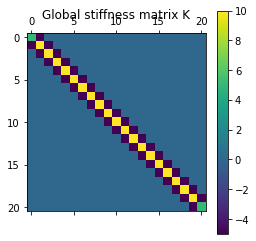

In [4]:
# Stiffness matrix
k = E*A/l
K = scipy.sparse.diags([-k, 2*k, -k], [-1, 0, 1], shape=(n_dofs, n_dofs)).toarray()
K[0,0] = k
K[n_dofs-1, n_dofs-1] = k
print('Matrix K')
print(K[:4,:4])
print(K[-4:,-4:])
plt.matshow(K)
plt.title('Global stiffness matrix K')
plt.colorbar()
plt.show()

Matrix M
[[0.1 0.  0. ]
 [0.  0.2 0. ]
 [0.  0.  0.2]]
[[0.2 0.  0. ]
 [0.  0.2 0. ]
 [0.  0.  0.1]]


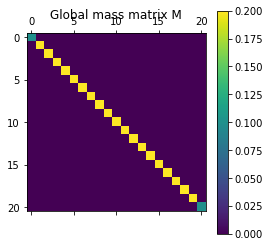

In [5]:
# Mass matrix
m = rho * A * l / 2
M = scipy.sparse.diags([2 * m], [0], shape=(n_dofs, n_dofs)).toarray()
M[0, 0] = m
M[n_dofs - 1, n_dofs - 1] = m
print('Matrix M')
print(M[:3, :3])
print(M[-3:, -3:])
plt.matshow(M)
plt.title('Global mass matrix M')
plt.colorbar()
plt.show()

In [6]:
print('Total mass')
print(np.trace(M))

Total mass
4.000000000000001


In [7]:
# Contact force as a function of indentation depth d.
def F_hertz(d):
    if d > 0:
        return 4.0 / 3.0 * E_star * R**0.5 * d**1.5
    else:
        return 0


    # Localization vector with 1 at the DoF of the impact and 0s elsewhere.
a_loc = np.zeros(n_dofs)
a_loc[0] = 1.0


def F(d):
    """
    Defines indentation dept-dependent vector of nodal loading forces.
    """
    return F_hertz(d) * a_loc

In [8]:
# Vector u stores nodal displacements, du nodal velocities.
# The first element of the vector u is the displacement the single DoF of impactor.
# Following elements are displacements of the DoFs of the elastic rod.
def func(u, du, t):
    """
    Some vector-valued function returning second derivatives.
    This function enters the odeint_2nd_order() function.
    """
    
    # Decompose displacements
    u0 = u[0]
    u_vec = u[1:]
    
    # Indentation depth
    d = u0 - u_vec[0]
    
    # Current contact force
    F_c = F_hertz(d)
    F_vec = F(d)
    
    M_inv = np.linalg.inv(M)    
    
    ddu0 = - 1.0 / m0 * F_c
    ddu_vec = np.matmul(M_inv, F_vec - np.matmul(K, u_vec))
    ddu = np.block([ddu0, ddu_vec])
    return ddu

In [9]:
# duration and timestep
T = 20.0
dt = l / c

# Time points
t = np.arange(0.0, T, dt)
n_times = len(t)
print("Number of time points: {}".format(n_times))

# Compose initial conditions for displacement and velocity.
u0_init = 0
du0_init = 0.01
u_vec_init = np.zeros(n_dofs)
du_vec_init = np.zeros(n_dofs)
u_init = np.block([u0_init, u_vec_init])
du_init = np.block([du0_init, du_vec_init])
print(u_init)
print(du_init)

# Integrate
u, du = odeint_2nd_order(func, u_init, du_init, t)


Number of time points: 101
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]


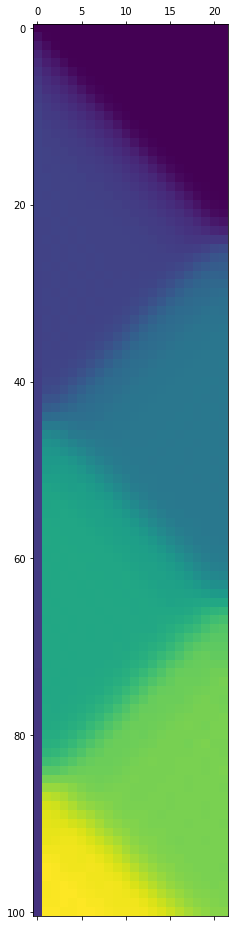

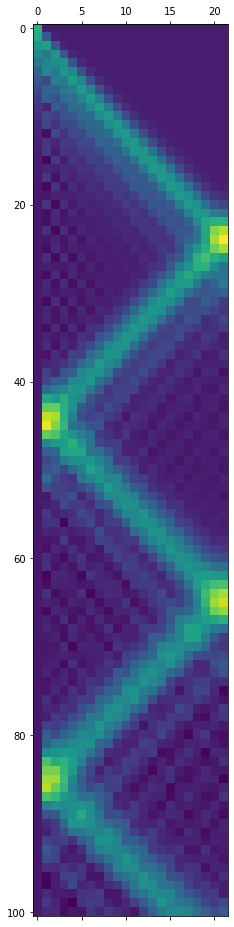

In [10]:
plt.matshow(u)
plt.show()
plt.matshow(du)
plt.show()

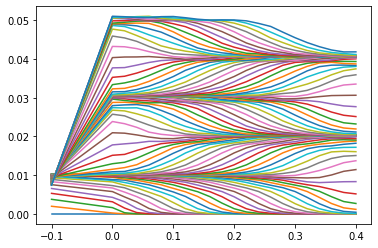

In [11]:
x_plot = np.block([-0.1, x])
for i in range(n_times):
    plt.plot(x_plot,u[i])
plt.show()

First few (10) eigenvalues lam = [-5.77511983e-15+0.j  6.15582970e-01+0.j  2.44717419e+00+0.j
  5.44967379e+00+0.j  9.54915028e+00+0.j  1.46446609e+01+0.j
  2.06107374e+01+0.j  2.73004750e+01+0.j  3.45491503e+01+0.j
  4.21782767e+01+0.j]


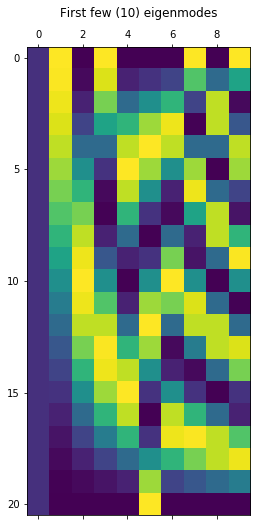

In [12]:
# Solving generalized eigenvalue problem (A - lam * B) * v = 0
# https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Generalized_eigenvalue_problem
# Columns of Q are eigenmodes.
lam, Q = scipy.linalg.eig(K, M)

# Sorting eigenvalues and eigenvectors
#idx = lam.argsort()[::-1] # Use when sorting from largest to smallest.
idx = lam.argsort() # Use when sorting from smallest to largest.
lam = lam[idx]
Q = Q[:,idx]

# Print first few modes
few = 10
print('First few ({}) eigenvalues lam = {}'.format(few, lam[:few]))
plt.matshow(Q[:,:few])
plt.title('First few ({}) eigenmodes'.format(few))
plt.show()

In [13]:
# Test the solution of the eigenvalue problem

def get_eigen_error(K, M, lam, Q, i):
    """
    Returns norm of vectors of residuals norm((K - lam_i * M) * Q_i).
    """
    residuals = np.matmul(K - lam[i] * M, Q[:, i])
    error = np.linalg.norm(residuals)
    return error

errors = np.array([get_eigen_error(K, M, lam, Q, i) for i in range(len(lam))])

print("Errors are: {}".format(errors))
print("Norm of all errors: {}".format(np.linalg.norm(errors)))


Errors are: [6.78236327e-15 9.85327369e-15 7.05822758e-15 6.47082287e-15
 5.99211959e-15 4.56475552e-15 7.39140551e-15 1.03748042e-14
 9.81967004e-15 1.35940328e-14 1.21312529e-14 1.25259673e-14
 1.37608326e-14 1.70672718e-14 1.32698133e-14 1.25764036e-14
 1.27342145e-14 2.35631677e-14 3.83055615e-14 2.31394430e-14
 2.35042369e-14]
Norm of all errors: 7.160005984394441e-14


In [14]:
print("Machine epsilon: {}".format(mach_eps))

print("Norm of errors is close to zero: {}".format(np.linalg.norm(errors) < math.sqrt(mach_eps)))

Machine epsilon: 2.220446049250313e-16
Norm of errors is close to zero: True


Number of all eigenmodes: 21


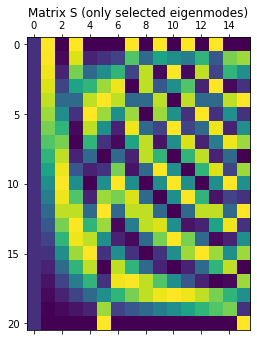

In [15]:
# Eigenmode decomposition method (Metoda rozkladu do vlastnich tvaru)
print("Number of all eigenmodes: {}".format(len(lam)))

#num_chosen_eigenmodes = len(lam) # Max size
num_chosen_eigenmodes = 16

# Now prepare matrix S containing n first eigenmodes
S = Q[:, :num_chosen_eigenmodes]
plt.matshow(S)
plt.title('Matrix S (only selected eigenmodes)')
plt.show()


Modal mass matrix m_mod:
(16, 16)


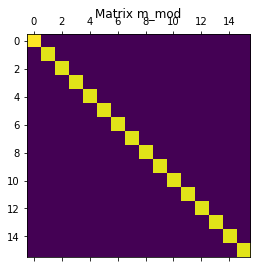

Modal stiffness matrix k_mod:
(16, 16)


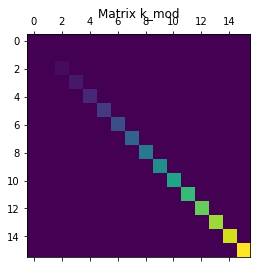

In [16]:
def transform_matrix(T, A):
    """
    Returns T^T * A * T
    """
    return np.matmul(np.transpose(T), np.matmul(A, T))


def transform_vector(T, a):
    """
    Returns T^T * a
    """
    return np.matmul(np.transpose(T), a)


# Compute modal mass matrix and modal stiffness matrix
m_mod = transform_matrix(S, M)
k_mod = transform_matrix(S, K)

# Print it
print("Modal mass matrix m_mod:")
print(np.shape(m_mod))
plt.matshow(m_mod)
plt.title('Matrix m_mod')
plt.show()
print("Modal stiffness matrix k_mod:")
print(np.shape(k_mod))
plt.matshow(k_mod)
plt.title('Matrix k_mod')
plt.show()



In [17]:
# Vector of modal loading, i.e. rhs of modal EoMs
# It depends on the value of indentation depth d.
# float -> 1D array
def f_mod(d):
    return np.matmul(np.transpose(S), F(d))


def f_mod_i(i):
    def inner_function(t):
        return f_mod(t)[i]
    return inner_function
    

y_init =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
dy_init =  [0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


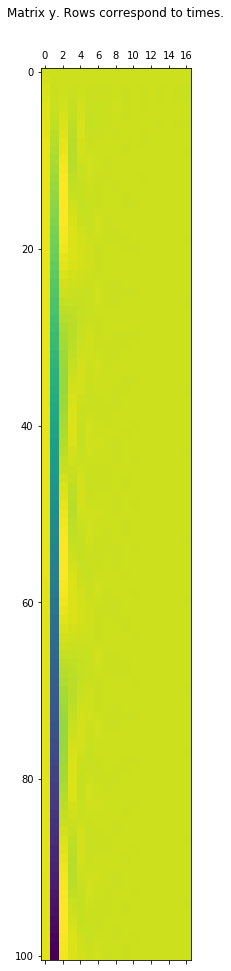

In [18]:
# Function to integrate

# Vector y stores nodal displacement of impactor u_im followed by modal coefficients q.  
# This particular function does not need first derivatives _dy to express second derivatives ddy.
def func_mod(y, _dy, t):
    """
    A vector-valued function returning second derivatives.
    This function enters the odeint_2nd_order() function.
    """
    
    # Decompose displacements
    u_im = y[0]
    q = y[1:]
    
    # Indentation depth
    d = u_im - np.matmul(np.transpose(a_loc), np.matmul(S, q))
        
    # Current contact force
    F_c = F_hertz(d)
    F_vec = F(d)
    
    m_mod_inv = np.linalg.inv(m_mod)    
    
    ddu_im = - 1.0 / m0 * F_c
    ddq = np.matmul(m_mod_inv, np.matmul(np.transpose(S), F_vec) - np.matmul(k_mod, q))
    ddy = np.block([ddu_im, ddq])
    return ddy

# Initial conditions
# Compose initial conditions for displacement and velocity.
u0_init = 0
du0_init = 0.01
q_vec_init = np.zeros(num_chosen_eigenmodes)
dq_vec_init = np.zeros(num_chosen_eigenmodes)
y_init = np.block([u0_init, q_vec_init])
dy_init = np.block([du0_init, dq_vec_init])

print("y_init = ", y_init)
print("dy_init = ", dy_init)


# Simultaneously integrate the EoM of the impactor
# and the system of EoMs in modal form.
y, dy = odeint_2nd_order(func_mod, y_init, dy_init, t)

plt.matshow(y)
plt.title("Matrix y. Rows correspond to times.")
plt.show()

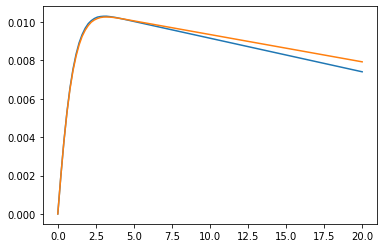

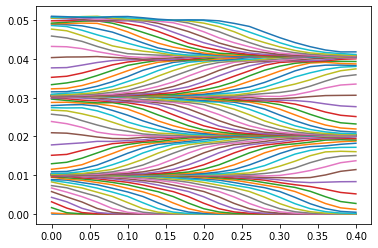

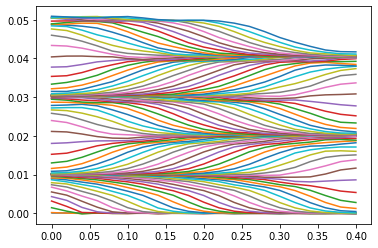

In [23]:
# Extract impactor and rod displacements

# Displacement of impactor - original version, no eigen analysis
u_imp_v1 = u[:, 0]
# Displacement of impactor - via eigenmode decomposition method
u_imp_v2 = y[:, 0]

u_rod_v1 = u[:, 1:]
q_rod = y[:, 1:]
# (n_times x n_nodes) = (n)
u_rod_v2 = np.matmul(q_rod, np.transpose(S))

# Plot both
plt.plot(t, u_imp_v1)
plt.plot(t, u_imp_v2)
plt.show()





# x-coordinates for plotting. Point for impactor added to the left.
x_plot = np.block([-0.1, x])

# Time integration, nodal unknowns
for i in range(n_times):
    plt.plot(x,u_rod_v1[i])
plt.show()

# Time integration, modal unknowns
for i in range(n_times):
    plt.plot(x,u_rod_v2[i])
plt.show()


In [ ]:
for i in range(n_times):
    plt.plot(x,u[i])
plt.show()

for i in range(n_times):
    plt.plot(x,u_nod[i])
plt.show()

In [ ]:
# Animate evolution of nodal displacement computed by modal decomposiion.

#%matplotlib inline
#%matplotlib notebook
# Simple animated chart
# Based on https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

fig = plt.figure()
ax = plt.axes(xlim=(np.amin(x), np.amax(x)), ylim=(np.amin(u_nod), np.amax(u_nod))) # Ranges of x and y axes
line, = ax.plot([], [], lw=2) # line object with empty data
#ax.set_title('')

def init():
    line.set_data([], [])
    #ax.set_title('')
    return line,

def animate(i):
    line.set_data(x, u_nod[i])
    ax.set_title('Time t = {}.'.format(t[i]))
    return line,

# Setting blit=True makes problems with animated title.
anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=False)
#anim.save('eom_odeint_animation.gif', writer='imagemagick')
anim.save('eom_odeint_animation_nod.mp4')



In [ ]:
from IPython.display import Video
Video("eom_odeint_animation.mp4")

In [ ]:
Video("eom_odeint_animation_nod.mp4")